#Test


In [1]:
from sklearn import preprocessing
import pandas as pd
import numpy as np
import prince
import seaborn as sns
from kmodes.kprototypes import KPrototypes
import matplotlib.pyplot as plt
from matplotlib import style
style.use("fivethirtyeight")
colors = ['b', 'orange', 'g', 'r', 'c', 'm', 'y', 'k', 'Brown', 'ForestGreen']
%matplotlib inline

First we read the data and view the data

In [2]:
data = pd.read_csv(r'players_20.csv')
data.head()

,sofifa_id,player_url,short_name,long_name,age,dob,height_cm,weight_kg,nationality,club,...,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb
0,158023,https://sofifa.com/player/158023/lionel-messi/...,L. Messi,Lionel Andrés Messi Cuccittini,32,1987-06-24,170,72,Argentina,FC Barcelona,...,68+2,66+2,66+2,66+2,68+2,63+2,52+2,52+2,52+2,63+2
1,20801,https://sofifa.com/player/20801/c-ronaldo-dos-...,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro,34,1985-02-05,187,83,Portugal,Juventus,...,65+3,61+3,61+3,61+3,65+3,61+3,53+3,53+3,53+3,61+3
2,190871,https://sofifa.com/player/190871/neymar-da-sil...,Neymar Jr,Neymar da Silva Santos Junior,27,1992-02-05,175,68,Brazil,Paris Saint-Germain,...,66+3,61+3,61+3,61+3,66+3,61+3,46+3,46+3,46+3,61+3
3,200389,https://sofifa.com/player/200389/jan-oblak/20/...,J. Oblak,Jan Oblak,26,1993-01-07,188,87,Slovenia,Atlético Madrid,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,183277,https://sofifa.com/player/183277/eden-hazard/2...,E. Hazard,Eden Hazard,28,1991-01-07,175,74,Belgium,Real Madrid,...,66+3,63+3,63+3,63+3,66+3,61+3,49+3,49+3,49+3,61+3


In [5]:
def get_cat(series: pd.Series, empty_flag: bool) -> str:
    """
    :param series: a pandas series of data (should be of one data type)
    :param empty_flag: a boolean to call out an empty column (containing all NaNs)
    :return: a string that is the 'category of the datatype'

    This function will take a given series and return a generalized category for the datatype.
    This is necessary for readability as df.dtypes will return ungrouped types (i.e. float64, int64)
    as well as return some options that do not provide much insight (i.e. object)
    """
    if empty_flag:  # Catch Empty Columns
        return 'Empty'
    elif pd.api.types.is_numeric_dtype(series):
        return 'Numerical'
    elif pd.api.types.is_datetime64_dtype(series):
        return 'Date'
    elif pd.api.types.is_bool_dtype(series):
        return 'Boolean'
    elif pd.api.types.is_categorical_dtype(series):
        return 'Categorical'
    elif pd.api.types.is_string_dtype(series):
        return 'Text'
    else:  # Catches all others for review
        return 'Unknown'


def col_categories(data: pd.DataFrame):
    """
    :param data: a pandas Dataframe consisting of columns of data you want to explore their categories
    :return: None
    Prints the column name and data type of each column in the dataframe
    """
    # if data.dropna().empty:  # Catches Error
    #     raise ValueError('DataFrame Provided Contains is either empty or only contains NaNs')
    #     # sys.exit(1)
    for col in data.columns:  # For Each Column
        if data[col].dropna().empty:  # Catch Empty Columns
            empty = True  # Set Flag
        else:
            empty = False  # Set Flag
        count = data[col].nunique()
        print(col, ': ', get_cat(data[col], empty), ' -- #Unique: ', count)  # Print and Call Column Categories

In [6]:
col_categories(data)



sofifa_id :  Numerical  -- #Unique:  18278
player_url :  Text  -- #Unique:  18278
short_name :  Text  -- #Unique:  17354
long_name :  Text  -- #Unique:  18218
age :  Numerical  -- #Unique:  27
dob :  Text  -- #Unique:  6142
height_cm :  Numerical  -- #Unique:  49
weight_kg :  Numerical  -- #Unique:  56
nationality :  Text  -- #Unique:  162
club :  Text  -- #Unique:  698
overall :  Numerical  -- #Unique:  47
potential :  Numerical  -- #Unique:  47
value_eur :  Numerical  -- #Unique:  214
wage_eur :  Numerical  -- #Unique:  141
player_positions :  Text  -- #Unique:  643
preferred_foot :  Text  -- #Unique:  2
international_reputation :  Numerical  -- #Unique:  5
weak_foot :  Numerical  -- #Unique:  5
skill_moves :  Numerical  -- #Unique:  5
work_rate :  Text  -- #Unique:  9
body_type :  Text  -- #Unique:  10
real_face :  Text  -- #Unique:  2
release_clause_eur :  Numerical  -- #Unique:  1224
player_tags :  Text  -- #Unique:  83
team_position :  Text  -- #Unique:  29
team_jersey_number :  

Need to drop certain columns that do not make sense for clustering
- Short Name
- Long Name
- URL

Need to Dummify Position
player traits
player tag

DOB Remove
Joined date for how long with team

Remove GK
remove national team and loan columns

Explain what we see, flags as numerical (but are binary) should be fine in our cluster

Lets look through a few of the variables to see the distribution (numerical with few options so
that our visuals are clean)





array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001C2A356B548>,
      dtype=object)

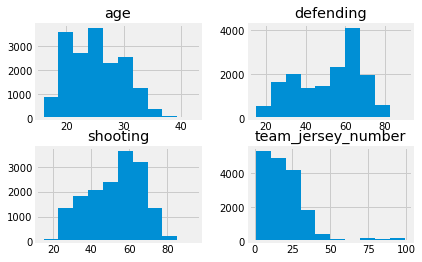

In [12]:
data = data[data['team_position'] != 'GK']
data[['age', 'team_jersey_number', 'defending', 'shooting']].hist()


In [13]:
print("-------Percentage of Null values count------")
for feature in data.columns.values:
    print(feature,"-->",100*data[feature].isnull().sum()/len(data))


-------Percentage of Null values count------
sofifa_id --> 0.0
player_url --> 0.0
short_name --> 0.0
long_name --> 0.0
age --> 0.0
dob --> 0.0
height_cm --> 0.0
weight_kg --> 0.0
nationality --> 0.0
club --> 0.0
overall --> 0.0
potential --> 0.0
value_eur --> 0.0
wage_eur --> 0.0
player_positions --> 0.0
preferred_foot --> 0.0
international_reputation --> 0.0
weak_foot --> 0.0
skill_moves --> 0.0
work_rate --> 0.0
body_type --> 0.0
real_face --> 0.0
release_clause_eur --> 7.135558583106267
player_tags --> 91.49069028156222
team_position --> 1.3623978201634876
team_jersey_number --> 1.3623978201634876
loaned_from --> 94.28360581289736
joined --> 7.078792007266122
contract_valid_until --> 1.3623978201634876
nation_position --> 94.07924613987284
nation_jersey_number --> 94.07924613987284
pace --> 7.799727520435967
shooting --> 7.799727520435967
passing --> 7.799727520435967
dribbling --> 7.799727520435967
defending --> 7.799727520435967
physic --> 7.799727520435967
gk_diving --> 92.200272

lots of missing features, but most still have atleast 35% values, so we will not be
removing any full features

In [18]:
# Drop the columns/rows where all elements are nan:
data.dropna(axis=1, how='all', inplace=True)
data.dropna(axis=0, inplace=True)  # For future should instead impute these

# Step 2: shall I standardise the data?
# What is the magnitude of data range?
# Only numerical variables needs to be scaled because catagorical variable cannot be scaled

num_col = data.select_dtypes(include=np.number).columns.tolist()
num_col.remove('SK_ID_CURR')

In [19]:
for i in num_col:
    data[i] = preprocessing.StandardScaler().fit_transform(data[[i]])

Onto clustering, explain why not kmean or kmode - mixed data type
explain algo


In [20]:
X = data[data.columns.values[1:]].values
cat_col = list(set(data.columns) - set(num_col))
cat_col.remove('SK_ID_CURR')
cat_col = sorted([data.columns.get_loc(c) -1 for c in cat_col if c in data])


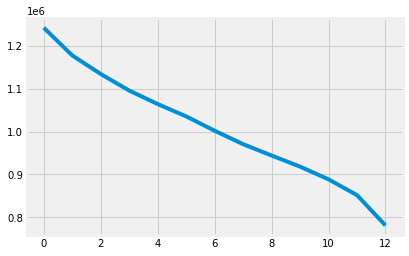

In [21]:
X2 = X[np.random.choice(len(X), size=6000, replace=True,)]
#Choosing optimal K
cost = []
for num_clusters in list(range(1,14)):
    kproto = KPrototypes(n_clusters=num_clusters, init='Cao')
    kproto.fit_predict(X2, categorical=cat_col)
    cost.append(kproto.cost_)

plt.plot(cost)

In [22]:
kproto = KPrototypes(n_clusters=6, init='Cao')
clusters = kproto.fit_predict(X, categorical=cat_col)



KeyboardInterrupt: 

In [ ]:
data['Cluster'] = kproto.labels_
sns.barplot(x=data.index, y = data['Cluster'])


Step 4: Dimensionality Reduction ###
Now we want to visualize the data from n diminesiton to 2 dimesion so we have to reduce the dimensionality of the
data.since our data has both categorical and numerical values so we have to use "facotor analysis for mixed data" technique
"Prince" package has this implementation

In [ ]:
famd = prince.FAMD(n_components=2, n_iter=3, copy=True, check_input=True, engine='auto')
famd = famd.fit(data)

ax = famd.plot_row_coordinates(data, ax=None, figsize=(12, 12), x_component=0, y_component=1,ellipse_outline=False,
                               ellipse_fill=True, show_points=True, color_labels=data['Cluster'])





In [ ]:
# # Step 5: profile the clusters (for a target variable)
# data.groupby('Cluster')['Rx'].mean().reset_index()